In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#malicious = 1
#benign = 0
df_training = pickle.load(open("end_user_attacks/20230517_fp_df_training.pkl", "rb"))

In [3]:
# df_training['TX_COUNT'] = 1
# for index, row in df_training.iterrows():
#     address = index
#     if not os.path.exists(f"end_user_attacks/{address}_4kpETDSTwUW83rFMYogo.pkl"):
#         print(f"File {address}_4kpETDSTwUW83rFMYogo.pkl does not exist")
#         continue
#     df_tx = pickle.load(open(f"end_user_attacks/{address}_4kpETDSTwUW83rFMYogo.pkl", "rb"))
#     tx_count = df_tx.iloc[0]['tx_count']
#     df_training.at[index, 'TX_COUNT'] = tx_count


#aggregating alert count per bot
bot_count_features = set()
for column in df_training.columns:
    bot_count_features.add(column[0:66])
bot_count_features.remove('label')

for bot_count_feature in bot_count_features:
    df_training[bot_count_feature + '_count'] = 0
    df_training[bot_count_feature + '_uniqalertid_count'] = 0


for index, row in df_training.iterrows():
    bot_id_unique_alert_ids = {}
    for column in df_training.columns:
        if column[0:66] in bot_count_features:
            count = row[column]
            df_training.loc[index, column[0:66] + '_count'] += count

            #increment unique alert id count if count > 0
            if column[0:66] not in bot_id_unique_alert_ids:
                bot_id_unique_alert_ids[column[0:66]] = 0

            if count > 0 and "_count" not in column:
                bot_id_unique_alert_ids[column[0:66]] += 1

    for column in df_training.columns:
        if "_uniqalertid_count" in column:
            df_training.loc[index, column] = bot_id_unique_alert_ids[column[0:66]]

df_training = df_training.sort_index(axis=1) #sort columns alphabetically

original_columns = df_training.columns
original_columns = original_columns.drop('label')
# for column in original_columns:
#     df_training[column+"_tx_normalized"] = 0

# for index, row in df_training.iterrows():
#     tx_count = row['TX_COUNT']
#     for column in original_columns:
#         df_training.loc[index, column+"_tx_normalized"] = row[column]*1.0/tx_count


In [4]:
len(df_training)

676

In [5]:
df_training.groupby("label").count()

,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_NFT-WASH-TRADE,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_count,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_uniqalertid_count,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_FUNDING,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_Laundering,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_NEW_FUNDING,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_count,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_uniqalertid_count,0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-1,0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-2,...,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE && SOFT-RUG-PULL-SUS-LIQ-POOL-CREATION,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE && SOFT-RUG-PULL-SUS-POOL-REMOVAL,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-POOL-REMOVAL,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-POOL-REMOVAL && SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_count,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_uniqalertid_count,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_CEX-FUNDING-1,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_count,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_uniqalertid_count
label,,,,,,,,,,,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,327,327,327
1,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349


In [6]:
df_training = df_training.astype("float64")
df_training.fillna(-1, inplace=True)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# split dateset into features and labels
x_data = df_training.drop(columns=['label'])#.reset_index(drop=True)
y_data = df_training["label"]#.reset_index(drop=True)

#scale the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(x_data)

# X_scaled_df = pd.DataFrame(X_scaled, columns=x_data.columns)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=42)


print(X_train.shape)
print(X_test.shape)

# rf = RandomForestClassifier(random_state=42)
# cv = StratifiedKFold(n_splits=5)

# # Use F1-score as the scoring metric
# rfe = RFECV(estimator=rf, step=1, cv=cv, scoring='f1', n_jobs=-1)
# rfe.fit(X_train, y_train)

# # Get the selected features
# selected_features = X_train.columns[rfe.support_]

# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# print(X_train_selected.shape)
# print(X_test_selected.shape)

weights = {0:1.0, 1:1.0}
# clf = SVC(kernel='linear',
#             class_weight='balanced', # penalize
#             probability=True)
#clf = tree.DecisionTreeClassifier(class_weight=weights, max_depth=6)
clf = RandomForestClassifier(class_weight=weights, max_depth=6, n_estimators=100, random_state=42)
# fit (train) the classifier
clf.fit(X_train, y_train)
#path = clf.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities
s = dump(clf, 'v4_scammer_model.joblib') 



(540, 117)
(136, 117)


In [52]:
from sklearn import metrics
#y_train_pred = clf.predict(X_train)
y_train_pred = clf.predict_proba(X_train)

#print (metrics.accuracy_score(y_train, y_train_pred))
precision, recall, thresholds = metrics.precision_recall_curve(y_train.values, list(zip(*y_train_pred))[0])
print(precision)
print(recall)
print(thresholds)

[0.51666667 0.51576994 0.51486989 0.51396648 0.5130597  0.51214953
 0.51123596 0.51031895 0.5093985  0.50847458 0.50754717 0.50661626
 0.50568182 0.50474383 0.50380228 0.50285714 0.5019084  0.50095602
 0.5        0.49904031 0.49807692 0.49710983 0.496139   0.49516441
 0.49418605 0.49320388 0.4922179  0.49122807 0.49023438 0.48923679
 0.48823529 0.48722986 0.48622047 0.4852071  0.48418972 0.48316832
 0.48214286 0.48111332 0.48007968 0.47904192 0.478      0.47695391
 0.47590361 0.47484909 0.47379032 0.47272727 0.47165992 0.47058824
 0.4695122  0.46843177 0.46734694 0.46625767 0.46516393 0.46406571
 0.46296296 0.4607438  0.45962733 0.45850622 0.45738046 0.45625
 0.45511482 0.4539749  0.45283019 0.45168067 0.45052632 0.44936709
 0.44820296 0.4470339  0.44585987 0.44468085 0.4434968  0.44230769
 0.44111349 0.43991416 0.43870968 0.4375     0.4362851  0.43506494
 0.43383948 0.4326087  0.43137255 0.430131   0.42888403 0.42763158
 0.42637363 0.42511013 0.42384106 0.42256637 0.42128603 0.42
 0.4

[0.51470588 0.51851852 0.52238806 0.52631579 0.53030303 0.53435115
 0.54263566 0.5511811  0.55555556 0.56       0.56451613 0.56910569
 0.5785124  0.58823529 0.59322034 0.5982906  0.60344828 0.60869565
 0.61403509 0.61946903 0.625      0.62162162 0.62727273 0.63302752
 0.65714286 0.66990291 0.67647059 0.68316832 0.69       0.6969697
 0.69387755 0.70103093 0.69791667 0.70212766 0.69892473 0.70652174
 0.71428571 0.72222222 0.73033708 0.73863636 0.73563218 0.73255814
 0.72941176 0.73809524 0.73170732 0.72839506 0.7375     0.73417722
 0.74358974 0.74025974 0.73684211 0.73333333 0.74324324 0.75342466
 0.76388889 0.77464789 0.78571429 0.7826087  0.79411765 0.79104478
 0.78787879 0.8        0.796875   0.79365079 0.80645161 0.80327869
 0.8        0.81355932 0.82758621 0.84210526 0.85714286 0.85454545
 0.85185185 0.8490566  0.84615385 0.84313725 0.84       0.83673469
 0.83333333 0.85106383 0.84782609 0.84444444 0.84090909 0.8372093
 0.83333333 0.82926829 0.825      0.82051282 0.81578947 0.810810

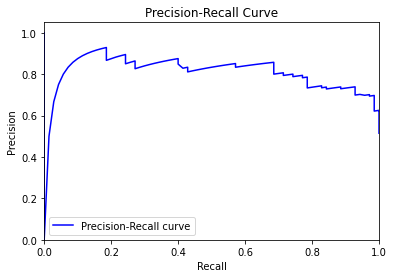

In [53]:
y_test_pred = clf.predict_proba(X_test)

#print (metrics.accuracy_score(y_train, y_train_pred))
precision, recall, thresholds = metrics.precision_recall_curve(y_test.values, list(zip(*y_test_pred))[1])
print(precision)
print(recall)
print(thresholds)
          
import matplotlib.pyplot as plt

# Plot the precision-recall curve
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [82]:
# 84 malicious total
# 72 benign total

# 109 traiing
# 47 testing

from sklearn.metrics import confusion_matrix

y_train_pred_thred = [1 if x > 0.84  else 0 for x in list(zip(*y_train_pred))[1]]

print("0 0 true negative")
print("0 1 false positives")
print("1 0 false negatives")
print("1 1 true positives")
cm = confusion_matrix(y_train,y_train_pred_thred)
print(cm)
print("pred malicous")

0 0 true negative
0 1 false positives
1 0 false negatives
1 1 true positives
[[260   1]
 [165 114]]
pred malicous


In [83]:
from sklearn.metrics import confusion_matrix

y_test_pred_thred = [1 if x > 0.84  else 0 for x in list(zip(*y_test_pred))[1]]

cm = confusion_matrix(y_test,y_test_pred_thred)
cm

array([[64,  2],
       [54, 16]])

In [56]:
df_y_test = pd.DataFrame(y_test)
df_y_test["pred"] = y_test_pred_thred
df_y_test.to_csv("y_test.csv")

In [57]:
y_test_pred

array([[0.20777486, 0.79222514],
       [0.33985248, 0.66014752],
       [0.10950485, 0.89049515],
       [0.83545354, 0.16454646],
       [0.11102964, 0.88897036],
       [0.40341321, 0.59658679],
       [0.29369147, 0.70630853],
       [0.95299742, 0.04700258],
       [0.09083771, 0.90916229],
       [0.19213962, 0.80786038],
       [0.16250064, 0.83749936],
       [0.74839758, 0.25160242],
       [0.12543084, 0.87456916],
       [0.27040407, 0.72959593],
       [0.15305597, 0.84694403],
       [0.41991417, 0.58008583],
       [0.53468624, 0.46531376],
       [0.64288061, 0.35711939],
       [0.11649808, 0.88350192],
       [0.48878092, 0.51121908],
       [0.71145625, 0.28854375],
       [0.1619281 , 0.8380719 ],
       [0.10974269, 0.89025731],
       [0.8287089 , 0.1712911 ],
       [0.90562024, 0.09437976],
       [0.44115489, 0.55884511],
       [0.62840952, 0.37159048],
       [0.78396259, 0.21603741],
       [0.93640675, 0.06359325],
       [0.53841014, 0.46158986],
       [0.

In [58]:
df_y_test[df_y_test["label"] == 1]

,label,pred
address,,
0xe7ebb56edf0cc4108060309e4cdd906448b7701d,1.0,1
0xe8f82befcde9a5d019cefed404c654f19b8cd789,1.0,0
0xff30b32c7e7da16cc7cd100a54ecd77b103d1a1c,1.0,1
0x82563ba592986cb277d67b2e7c56ab3bb3fdd6b8,1.0,0
0xf98ec07d4609c4e6142c7487f170b775c9242445,1.0,1
...,...,...
0x49dc14dd851b6eae8d685715e12a06cc1bfc5d8d,1.0,1
0x71555fd3c87db56738b25f497302fd33f636cf04,1.0,1
0x7c420a00a3264538e0a5c3af4ea02be5af7d8c9e,1.0,1


In [59]:
X_test.loc["0x5c108c488df3b5742fe71e387a899687f959093e"]

KeyError: '0x5c108c488df3b5742fe71e387a899687f959093e'

In [ ]:
y_test_pred

array([[0.24624471, 0.75375529],
       [0.68583472, 0.31416528],
       [0.83900453, 0.16099547],
       [0.82208245, 0.17791755],
       [0.30166342, 0.69833658],
       [0.30814358, 0.69185642],
       [0.75510781, 0.24489219],
       [0.0611366 , 0.9388634 ],
       [0.32869879, 0.67130121],
       [0.91250458, 0.08749542],
       [0.75510781, 0.24489219],
       [0.74584551, 0.25415449],
       [0.40428037, 0.59571963],
       [0.07970903, 0.92029097],
       [0.30003357, 0.69996643],
       [0.70726292, 0.29273708],
       [0.22785089, 0.77214911],
       [0.9644433 , 0.0355567 ],
       [0.24099977, 0.75900023],
       [0.02558622, 0.97441378],
       [0.11818995, 0.88181005],
       [0.30166342, 0.69833658],
       [0.75510781, 0.24489219],
       [0.08882968, 0.91117032],
       [0.60808252, 0.39191748],
       [0.30214793, 0.69785207],
       [0.03899343, 0.96100657],
       [0.4810971 , 0.5189029 ],
       [0.03154647, 0.96845353],
       [0.02038287, 0.97961713],
       [0.

In [ ]:
X_test

,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_NFT-WASH-TRADE,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_count,0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_uniqalertid_count,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_FUNDING,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_Laundering,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_NEW_FUNDING,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_count,0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_uniqalertid_count,0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-1,0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-2,...,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE && SOFT-RUG-PULL-SUS-LIQ-POOL-CREATION,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE && SOFT-RUG-PULL-SUS-POOL-REMOVAL,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-POOL-REMOVAL,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_SOFT-RUG-PULL-SUS-POOL-REMOVAL && SOFT-RUG-PULL-SUS-LIQ-POOL-RESERVE-CHANGE,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_count,0xf234f56095ba6c4c4782045f6d8e95d22da360bdc41b75c0549e2713a93231a4_uniqalertid_count,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_CEX-FUNDING-1,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_count,0xf496e3f522ec18ed9be97b815d94ef6a92215fc8e9a1a16338aee9603a5035fb_uniqalertid_count
address,,,,,,,,,,,,,,,,,,,,,
0x0e0bb0cc029c221277329552403c976e1bd176d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x4eef32f009299658c0522742665a9f45e064a82c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x0b310c6cda53b115c49f1c8845a9d733ed9c9c8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
0xc98abab9e3d9a50b09e0603c29c66327bca02915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x5c108c488df3b5742fe71e387a899687f959093e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x3e6719a75fc8d46a6a0943112424a7b73cb936e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x0b4a5018ae0e2779351e703a58d78cf10eae3d7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xf8137be31b516f481e25f4f09f173ec26a5ba649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#graph on training data (excluding test dataß)

import graphviz 
#features = X_train_selected.columns
features = X_train.columns
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      class_names=["benign","attacker"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph



AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [84]:
X_train.columns[0:50]


Index(['0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_NFT-WASH-TRADE',
       '0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_count',
       '0x067e4c4f771f288c686efa574b685b98a92918f038a478b82c9ac5b5b6472732_uniqalertid_count',
       '0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_FUNDING',
       '0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_Laundering',
       '0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_FLD_NEW_FUNDING',
       '0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_count',
       '0x186f424224eac9f0dc178e32d1af7be39506333783eec9463edd247dc8df8058_uniqalertid_count',
       '0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-1',
       '0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-2',
       '0x1a69f5ec8ef436e4093f9ec4ce1a55252b7a9a2d2c386e3f950b79d164bc99e0_NIP-4',
       '0x1a69f5ec8ef436e4093

In [85]:
X_train.columns[50:]

Index(['0x7cfeb792e705a82e984194e1e8d0e9ac3aa48ad8f6530d3017b1e2114d3519ac_uniqalertid_count',
       '0x887678a85e645ad060b2f096812f7c71e3d20ed6ecf5f3acde6e71baa4cf86ad_NON-MALICIOUS-TOKEN-CONTRACT-CREATION',
       '0x887678a85e645ad060b2f096812f7c71e3d20ed6ecf5f3acde6e71baa4cf86ad_SAFE-TOKEN-CONTRACT-CREATION',
       '0x887678a85e645ad060b2f096812f7c71e3d20ed6ecf5f3acde6e71baa4cf86ad_SUSPICIOUS-TOKEN-CONTRACT-CREATION',
       '0x887678a85e645ad060b2f096812f7c71e3d20ed6ecf5f3acde6e71baa4cf86ad_count',
       '0x887678a85e645ad060b2f096812f7c71e3d20ed6ecf5f3acde6e71baa4cf86ad_uniqalertid_count',
       '0x8badbf2ad65abc3df5b1d9cc388e419d9255ef999fb69aac6bf395646cf01c14_ICE-PHISHING-APPROVAL-FOR-ALL',
       '0x8badbf2ad65abc3df5b1d9cc388e419d9255ef999fb69aac6bf395646cf01c14_ICE-PHISHING-ERC1155-APPROVAL-FOR-ALL',
       '0x8badbf2ad65abc3df5b1d9cc388e419d9255ef999fb69aac6bf395646cf01c14_ICE-PHISHING-ERC1155-APPROVAL-FOR-ALL-INFO',
       '0x8badbf2ad65abc3df5b1d9cc388e419d9255ef999f